# SRCNet simulated test data walk-through

This notebook is based on the script SRCNet_v0.1_simulation.py.  
It explains step by step how simulated test data (visibilities and dirty images) for SRCNet v0.1 can be generated.  
Parameters have been adjusted compared to the script to allow you to run it on your laptop in a matter of minutes.

In [1]:
from datetime import datetime, timedelta, timezone

from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulator_backend import SimulatorBackend

The RASCIL data directory is not available - continuing but any simulations will fail


In [2]:
# Render plots inline
%matplotlib inline

## Simulation

Choose simulation backend software

In [3]:
SIMULATOR_BACKEND = SimulatorBackend.OSKAR

### Survey

Choose sky model, i.e. survey.  
Metadata of the survey: https://archive.sarao.ac.za/search/MIGHTEE%20COSMOS/target/J0408-6545/captureblockid/1587911796/

In [4]:
sky_model = SkyModel.get_MIGHTEE_Sky()

In [5]:
# Phase center: should be mean of coverage
# Means of values from sky model description
phase_center_ra = 150.12
phase_center_dec = 2.21
phase_center = [phase_center_ra, phase_center_dec]

Let's have a look at our sky.

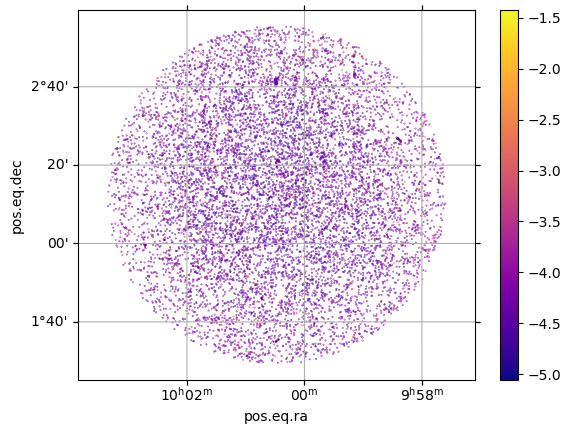

In [6]:
sky_model.setup_default_wcs(phase_center=phase_center)
sky_model.explore_sky(phase_center, s=0.1)

### Telescope

Choose telescope and visualize it

In [7]:
# Size of generated visibilities scales quadratically with the number of baselines
telescope = Telescope.constructor(
    name="MeerKAT",
    backend=SIMULATOR_BACKEND,
)

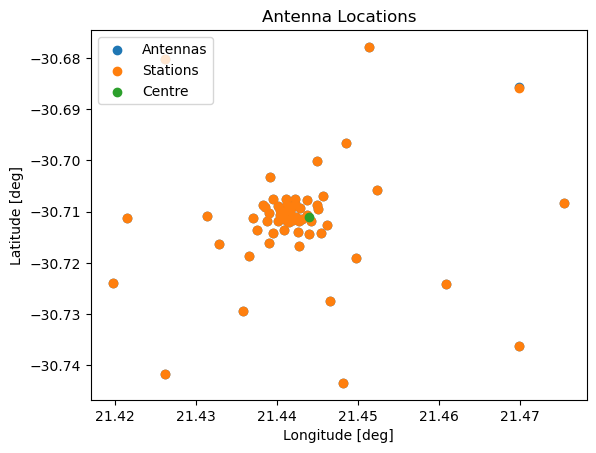

In [8]:
telescope.plot_telescope()

### Run simulation

Choose simulation parameters

In [9]:
# From sky model description
start_frequency_hz = 1.304e9
end_frequency_hz = 1.375e9
# ~ center frequency
observation_start_frequency_hz = 1.34e9

# From survey metadata
frequency_increment_hz = 26123

# Size of generated visibilities scales linearly with this
number_of_channels = 8

# Original survey: 3593 dumps => Size: 6668.534 GB
# Size of generated visibilities scales linearly with this
number_of_time_steps = 8

Wavelength @ 1340 MHz = 0.22372571 m  
MeerKAT dish diameter = 13 m  
FOV = Beam Width (FWHM) = 1.2 * 0.22372571 m / 13 m = 0.020651604 rad = 1.1832497493784 deg

Initialize simulation, configure primary beam parameters

In [10]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=frequency_increment_hz,
    station_type="Gaussian beam",
    gauss_beam_fwhm_deg=1.1832497493784,
    gauss_ref_freq_hz=1.34e9,
)

Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.


Initialize and configure observation

In [11]:
observation = Observation(
    phase_centre_ra_deg=phase_center_ra,
    phase_centre_dec_deg=phase_center_dec,
    # During the chosen time range [start, start + length]
    # sources shouldn't be behind horizon, otherwise we won't see much.
    # Original survey: 2020-04-26 14:36:50.820 UTC to 2020-04-26 22:35:42.665 UTC
    start_date_and_time=datetime(2020, 4, 26, 18, 36, 0, 0, timezone.utc),
    # Dump rate from survey metadata
    length=timedelta(seconds=number_of_time_steps * 7.997),
    number_of_time_steps=number_of_time_steps,
    number_of_channels=number_of_channels,
    start_frequency_hz=observation_start_frequency_hz,
    frequency_increment_hz=frequency_increment_hz,
)

Run simulation, generate visibilities

In [12]:
visibility = simulation.run_simulation(
    telescope,
    sky_model,
    observation,
    backend=SIMULATOR_BACKEND,
)

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-YYCVi5cqxj for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-YYCVi5cqxj/visibility.vis


## Imaging

Choose imaging parameters

In [13]:
# Image size in degrees should be smaller than FOV
# Bigger baseline -> higher resolution
imaging_npixel = 4096

# Cellsize < FOV / 4096 -> 0.0000050418955078125
imaging_cellsize = 5e-6

### Dirty image

Create dirty image using WSClean

In [14]:
dirty_imager = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
        combine_across_frequencies=True,
    )
)
dirty_image = dirty_imager.create_dirty_image(visibility)

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-dirty-Iao4vf8tnK for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-dirty-Iao4vf8tnK && OPENBLAS_NUM_THREADS=1 wsclean -size 4096 4096 -scale 0.00028647889756541165deg /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-YYCVi5cqxj/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  1340-1340 (8)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-YYCVi5cqxj/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-16128; 16128 rows)
Detected 11.7 GB of system me

Let's have a look at our dirty image

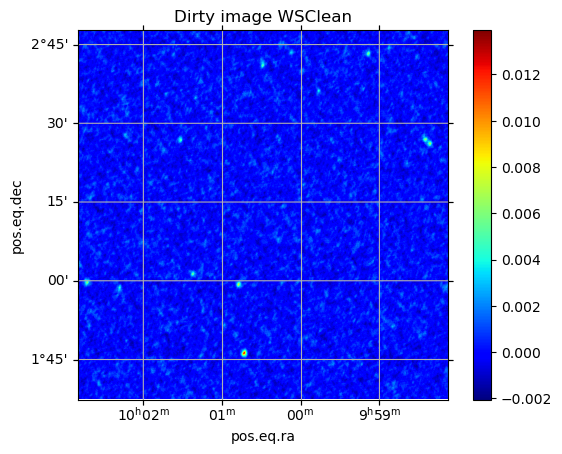

In [15]:
dirty_image.plot(title="Dirty image WSClean")

### Clean image

Clean image using WSClean

In [16]:
cleaned_image = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(visibility)

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-bQFyYEMbnv for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-bQFyYEMbnv && OPENBLAS_NUM_THREADS=1 wsclean -size 4096 4096 -scale 0.00028647889756541165deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-YYCVi5cqxj/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  1340-1340 (8)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-YYCVi5cqxj/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10

Plot cleaned image

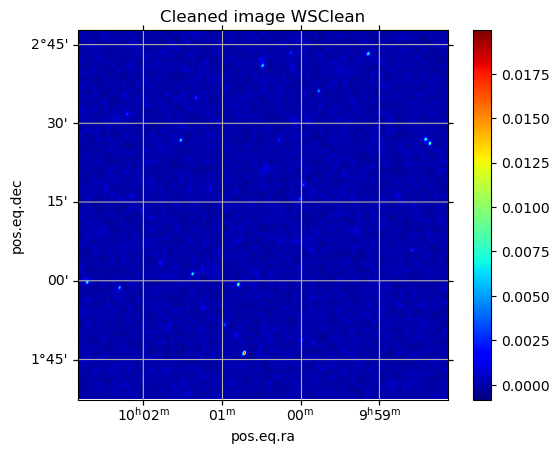

In [17]:
cleaned_image.plot(title="Cleaned image WSClean")